In [1]:
#!pip3 install psycopg2-binary
#!pip3 install python-dotenv
#!pip3 install pandas
#!pip3 install matplotlib
#!pip3 install ipympl
#!pip3 install keplergl geopandas
#!pip3 install ipywidgets
#!pip3 install widgetsnbextension
#!pip3 install folium
#!pip3 install  ipyvolume

In [2]:
!jupyter nbextension enable --py keplergl
!jupyter nbextension enable --py widgetsnbextension
#!jupyter labextension install jupyter-matplotlib@0.3.0 --minimize=false --debug
#!jupyter labextension install jupyter-plotly --minimize=false --debug

Enabling notebook extension keplergl-jupyter/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
!jupyter labextension list

JupyterLab v3.0.3
/home/shorsh/.local/share/jupyter/labextensions
        jupyterlab-datawidgets v7.0.0 enabled OK
        jupyter-matplotlib v0.8.2 enabled OK
        @jupyter-widgets/jupyterlab-manager v3.0.0 enabled OK (python, jupyterlab_widgets)

Other labextensions (built into JupyterLab)
   app dir: /home/shorsh/.local/share/jupyter/lab
        jupyter-threejs v2.2.0 enabled OK


Build recommended, please run `jupyter lab build`:
    jupyter-threejs needs to be included in build


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import psycopg2
import yaml
import pandas as pd
import pandas.io.sql as sqlio
import ipyvolume as ipv
import ipyvolume.pylab as p3
import numpy as np
import ipywidgets
import folium
from keplergl import KeplerGl 


In [5]:
with open(os.getcwd()+"/config.yml", 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

In [6]:
PGHOST = cfg['db_creds']['PGHOST']
PGDATABASE =  cfg['db_creds']['PGDATABASE']
PGUSER =  cfg['db_creds']['PGUSER']
PGPASSWORD =  cfg['db_creds']['PGPASSWORD']

In [7]:

def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+ PGHOST +" port="+ "5432" +" dbname="+ PGDATABASE +" user=" + PGUSER \
                  +" password="+ PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    print("Connected!")

    # Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

In [8]:
conn, cursor = connect()

Connected!


In [9]:
sql = "select * from public.data1_final_mv where ord =1;"
df = sqlio.read_sql_query(sql, conn)

In [10]:
print(len(df))

293336


In [11]:
cursor.close()
conn.close()

In [12]:
df.head()
df2 = df

In [13]:
# Converting column to datetime
df2['start_date_time']=pd.to_datetime(df2['start_time'])
df2['start_time']=pd.to_datetime(df2['start_date_time']).dt.time
# Creating hour column
df2['hour']=df2['start_date_time'].apply(lambda x: x.hour)
df2.head()

,good_id,start_time,call_duration_seconds,first_latitude,first_longitude,last_latitude,last_longitude,ord,start_date_time,hour
0,1659e454818481591803564722,15:39:25,85,42.742,-86.175,42.761,-86.156,1,2020-10-06 15:39:25,15
1,1659ec256c4231591790390561,11:59:51,26,42.725,-84.458,42.725,-84.458,1,2020-10-06 11:59:51,11
2,1659ff9ab4c7e1591800663005,14:51:03,28,28.411,-81.339,28.44,-81.338,1,2020-10-06 14:51:03,14
3,165a6482454921591782843000,09:54:03,51,39.936,-82.884,39.937,-82.884,1,2020-10-06 09:54:03,9
4,165a7788d6a4f1591782475276,09:47:55,70,36.389,-80.731,36.389,-80.731,1,2020-10-06 09:47:55,9


In [14]:
df.describe()

,call_duration_seconds,ord,hour
count,293336.000000,293336.0,293336.000000
mean,95.515368,1.0,12.446403
std,664.618163,0.0,3.631581
min,0.000000,1.0,0.000000
25%,0.000000,1.0,9.000000
50%,10.000000,1.0,13.000000
75%,98.000000,1.0,16.000000
max,43895.000000,1.0,23.000000


# Analyze amount of calls during hours

<AxesSubplot:xlabel='hour'>

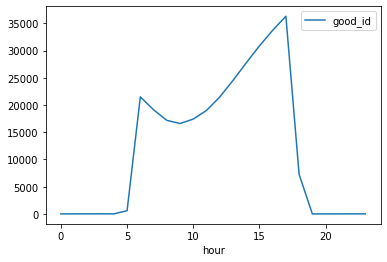

In [15]:
df2[['hour', 'good_id']].groupby('hour').count().plot()

# Remove 0 duration calls 

<AxesSubplot:xlabel='hour'>

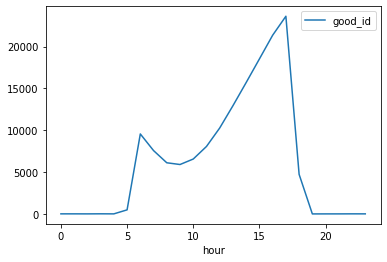

In [16]:
df_no_zero = df2[df2['call_duration_seconds'].astype(float) > 0]
df_no_zero[['hour', 'good_id']].groupby('hour').count().plot()

# Analyze histogram of call durations

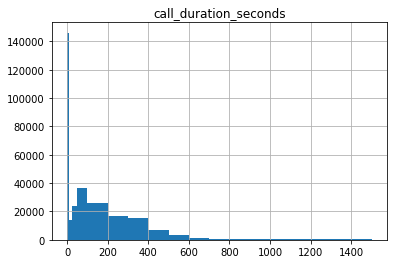

In [17]:
df.hist(column='call_duration_seconds', bins=[0,10,25,50,100,200,300,400,500,600,700,800,900,1000,1500]);


# Analyze histogram no zero calls

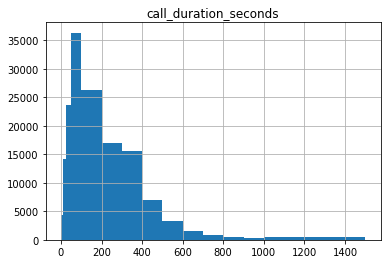

In [18]:
df_no_zero.hist(column='call_duration_seconds', bins=[0,10,25,50,100,200,300,400,500,600,700,800,900,1000,1500]);

In [19]:
df.to_csv('../processed-data/data1.csv')

## Check moving calls

In [20]:
df_moving_calls = df[df['last_latitude']!= 'NA' ]
df_moving_calls.to_csv('../processed-data/data1_moving.csv')

## Clean 0,0 latitudes and longitudes

In [21]:
df_moving_calls = df_moving_calls[df_moving_calls['first_latitude'].astype(float) != 0]
#print(df_moving_calls)
df_moving_calls.to_csv('../processed-data/data1_moving_clean.csv')

In [22]:
#df_moving_calls[df_moving_calls['good_id'] == '7616865064c7a1591608163330']

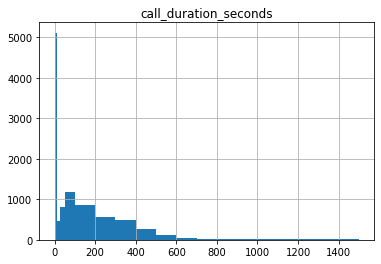

In [23]:
df_sample = df.sample(n=10000)
df_sample.hist(column='call_duration_seconds', bins=[0,10,25,50,100,200,300,400,500,600,700,800,900,1000,1500]);


In [24]:
df_sample.to_csv('../processed-data/data1_sample.csv')

# Report 1

Distribution of calls in North America

![title](../reports/data1_calls_location.png)

# Report2 

Moving Calls that start and end on different latitude and longitude

![title](../reports/data1_moving_calls.png)

# Report 3

Cleaned sites starting or ending at latitude and longitude (0,0)

![title](../reports/data1_moving_clean.png)

# Report4 

HeatMap with moving time window with Sampled data as Kepler was crashing with 300k points of data. Concentrated the graphs in the US to appreciate the heatmap

![title](../reports/data1_heatmap.png)